In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.mask import mask
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

## Part 1

In [2]:
#Q1
counties = gpd.read_file("counties.geojson")
len(counties)

72

(                  NAME  POP100  \
 32       Oneida County   35998   
 44       Forest County    9304   
 39        Green County   36842   
 1         Clark County   34690   
 12        Dodge County   88759   
 18    Marinette County   41749   
 13      Burnett County   15457   
 64        Brown County  248007   
 24         Polk County   44205   
 40   Green Lake County   19051   
 11  Fond du Lac County  101633   
 61      Calumet County   48971   
 20     Chippewa County   62415   
 31    Jefferson County   83686   
 46     Crawford County   16644   
 45    La Crosse County  114638   
 41       Pierce County   41019   
 55     Columbia County   56833   
 5       Buffalo County   13587   
 23     Walworth County  102228   
 36    Sheboygan County  115507   
 60      Lincoln County   28743   
 6     Winnebago County  166994   
 16      Shawano County   41949   
 7      Waukesha County  389891   
 43    Manitowoc County   81442   
 49       Oconto County   37660   
 0        Racine Cou

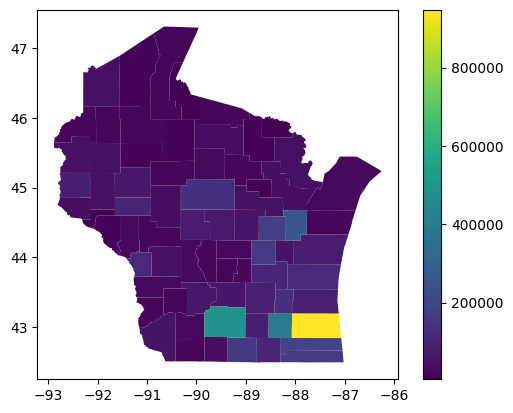

In [3]:
#Q2
fig, ax = plt.subplots()
geo_plot = counties.plot(column = 'POP100', ax = ax, legend = True)
plt.plot()

db = sqlite3.connect("counties_tracts.db")
temp_df = pd.read_sql("SELECT NAME, arealand FROM counties", db)
counties = counties.merge(temp_df, on = 'NAME', how = 'left')

train,test = train_test_split(counties, random_state=250, test_size=0.25)
train,test

In [4]:
#Q3
test["NAME"].tolist()

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [5]:
#Q4
x_train = train[["AREALAND"]]
y_train = train[["POP100"]]
x_test = test[["AREALAND"]]
y_test = test[["POP100"]]

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
lin_reg.score(x_test,y_test)

0.016720430179409274

In [6]:
#Q5
temp_df = pd.DataFrame({"AREALAND": [600*2.59*(1000**2)]})
predicted_value = lin_reg.predict(temp_df)
predicted_value[0][0]

78504.52061277494

## Part 2

In [7]:
#Q6
tracts_df = pd.read_sql("""SELECT SUM(tracts.HU100) as HU100, counties.NAME FROM tracts LEFT JOIN counties ON tracts.COUNTY = counties.COUNTY GROUP BY counties.NAME""", db)
counties = counties.merge(tracts_df)
train, test = train_test_split(counties, test_size=0.25, random_state=250)
test["NAME"].tolist()

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [8]:
#Q7
hu100_test_df = test[['NAME', 'HU100']]
pd.Series(hu100_test_df.HU100.values, index=hu100_test_df.NAME).to_dict()

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [9]:
#Q8
X_train = train[["HU100"]]
y_train = train[["POP100"]]
X_test = test[["HU100"]]
y_test = test[["POP100"]]

lin_reg = LinearRegression()
cv_scores = cross_val_score(lin_reg, X_train, y_train, cv=5)
np.mean(cv_scores)

0.9739348181232653

In [10]:
#Q9
cv_scores.std()

0.01693954236334351

In [11]:
#Q10
lin_reg.fit(X_train, y_train)
coefficient = round(lin_reg.coef_[0][0], 2)
intercept = round(lin_reg.intercept_[0], 2)
formula = f"POP100 = {coefficient}*HU100 + {intercept}"
formula

'POP100 = 2.47*HU100 + -9276.89'

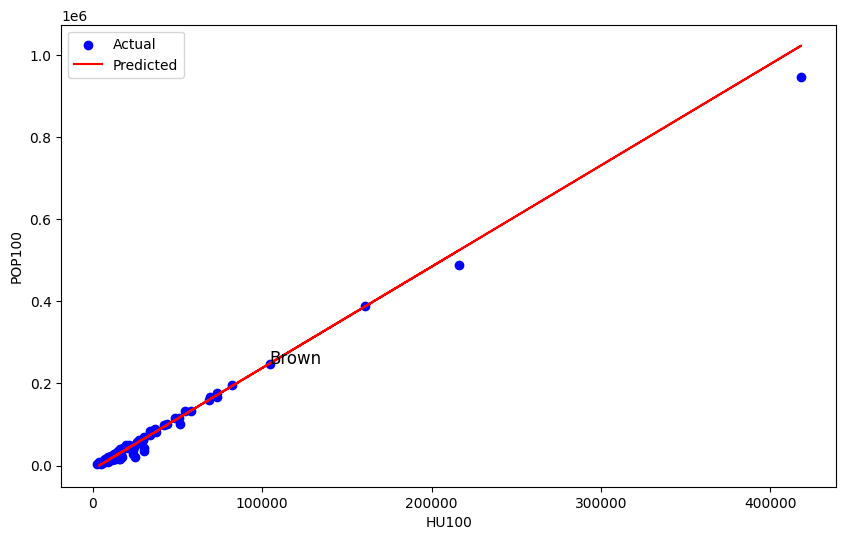

In [12]:
#Q11
X_combined = counties[["HU100"]]
y_combined = counties[["POP100"]]
# counties['Predicted_POP100'] = lin_reg.predict(X_combined)
y_pred = lin_reg.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(counties['HU100'], counties['POP100'], color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')

brown_county_value = counties[counties['NAME'] == 'Brown County']
plt.text(brown_county_value['HU100'], brown_county_value['POP100'], 'Brown', fontsize=12)

plt.legend()
plt.xlabel('HU100')
plt.ylabel('POP100')
plt.show()

## Part 3

In [13]:
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

In [14]:
#Q12
np.sum((A >= 3) & (A <= 6))

8

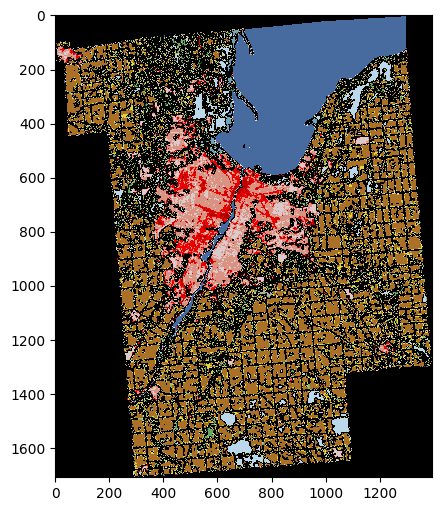

In [15]:
#Q13
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land = rasterio.open("zip:land.zip!")
counties = counties.to_crs(land.crs)
geometry = counties[counties["NAME"] == "Brown County"]["geometry"].values[0]
maxtrix, _ = mask(land, [geometry], crop =True)
matrix = maxtrix[0]
fig, ax = plt.subplots(figsize=(6,6))
img = ax.imshow(matrix, vmin=0, vmax=255, cmap = custom_cmap)

In [16]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}


In [17]:
#Q14
open_water = np.sum(matrix == 11)
total = np.sum(matrix > 0)
open_water / total


0.13797526789725206

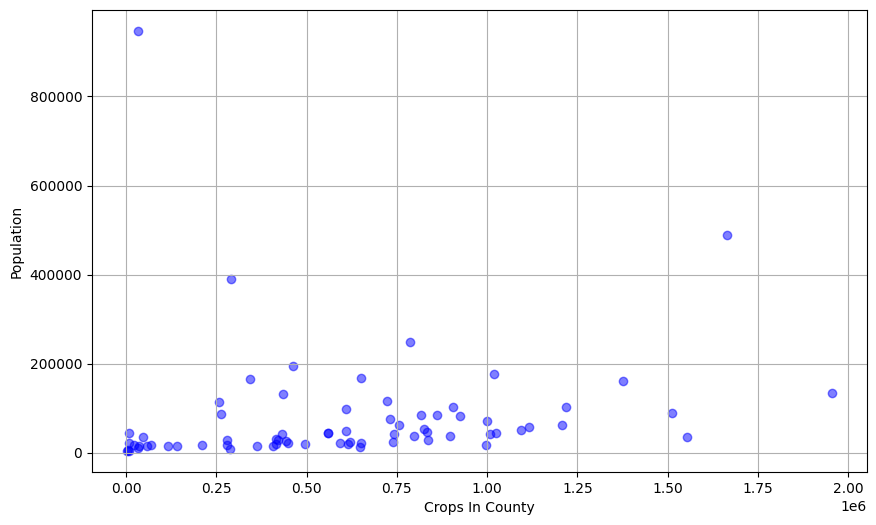

In [18]:
#Q15
crops = []
county_populations = []

for idx, rec in counties.iterrows():
    shape = rec['geometry'] 
    raster_output, _ = mask(land, [shape], crop=True)
    land_matrix = raster_output[0]
    crop = np.sum(land_matrix == land_use['crops'])
    crops.append(crop)
    county_populations.append(rec['POP100'])
    
plt.figure(figsize=(10, 6))
plt.scatter(crops, county_populations, color='blue', alpha=0.5)
plt.xlabel('Crops In County')
plt.ylabel('Population')
plt.grid()
plt.show()


## Individual Part

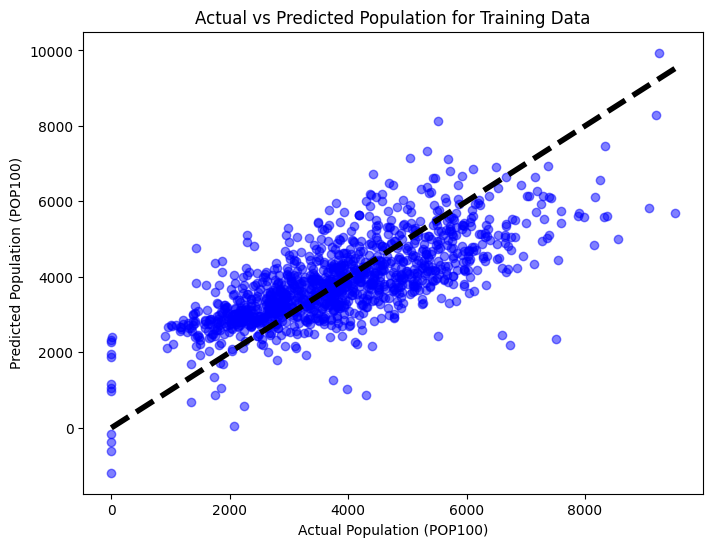


The graph above plots the actual population values from the training dataset against the predicted population values obtained from our linear regression model. The closer the data points lie to the diagonal dashed line, the more accurate our predictions are.

From the graph, we can observe how well the model generalizes the training data. If the points significantly deviate from the diagonal line, it might indicate issues such as underfitting or overfitting, or that linear regression may not be capturing all the nuances of the relationship between land use and population.

The insights gained from this graph could be used to:
1. Evaluate the necessity of adding more features or employing polynomial regression to capture more complex relationships.
2. Investigate specific outliers or leverage points that might influence the model disproportionately and assess if more granular data cleaning is needed.
3. Consider alternative modeling techniques such as decision trees or ensemble methods

In [19]:
#Part1
tracts = gpd.read_file('tracts.shp')

# Open the land raster data
with rasterio.open("zip://land.zip") as land:
    # Ensure all tracts are transformed to match the CRS of the land data
    tracts = tracts.to_crs(land.crs)

    for idx, row in tracts.iterrows():
        # Mask the land data for the current tract's geometry
        matrix, _ = mask(land, [row['geometry']], crop=True)
        matrix = matrix[0]  # Assuming there's only one layer

        # Compute totals for each land use type and store them in the respective column
        for key in land_use:
            total = np.sum(matrix == land_use[key])
            tracts.at[idx, key] = total
train, test = train_test_split(tracts, random_state = 300, test_size = 0.20)
X_train = train[list(land_use.keys())]
y_train = train[["POP100"]]
X_test = test[list(land_use.keys())]
y_test = test[["POP100"]]
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_train)

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred, alpha=0.5, color='blue')
plt.xlabel('Actual Population (POP100)')
plt.ylabel('Predicted Population (POP100)')
plt.title('Actual vs Predicted Population for Training Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)  # Line for perfect predictions
plt.show()
print("""
The graph above plots the actual population values from the training dataset against the predicted population values obtained from our linear regression model. The closer the data points lie to the diagonal dashed line, the more accurate our predictions are.

From the graph, we can observe how well the model generalizes the training data. If the points significantly deviate from the diagonal line, it might indicate issues such as underfitting or overfitting, or that linear regression may not be capturing all the nuances of the relationship between land use and population.

The insights gained from this graph could be used to:
1. Evaluate the necessity of adding more features or employing polynomial regression to capture more complex relationships.
2. Investigate specific outliers or leverage points that might influence the model disproportionately and assess if more granular data cleaning is needed.
3. Consider alternative modeling techniques such as decision trees or ensemble methods that might handle non-linear relationships more effectively.

Ultimately, this visualization aids in iterative model refinement, prompting adjustments based on observed performance and leading towards a more robust predictive model.
""")

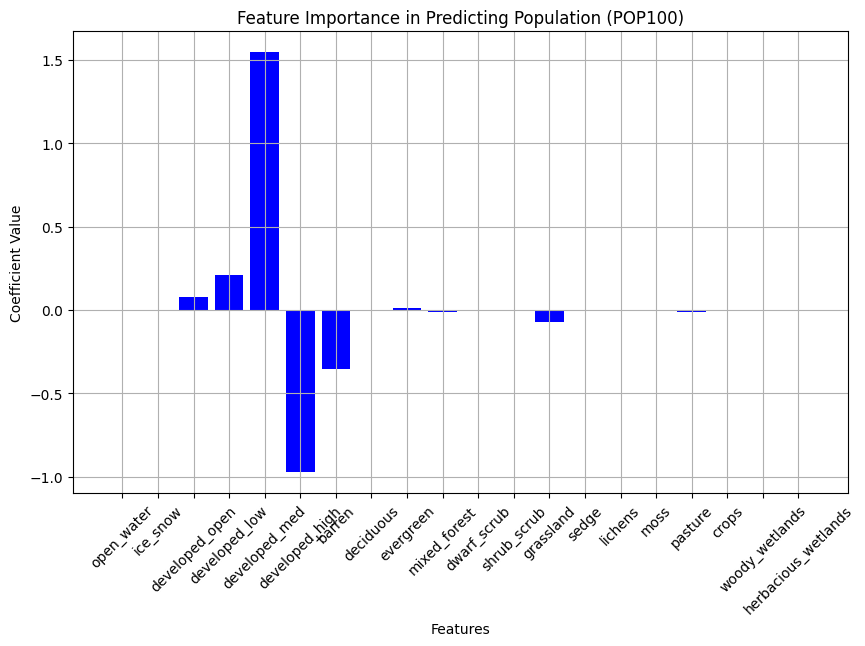

The bar graph shows the influence of different land use types on population prediction. Features like developed_high positively correlate with population, suggesting such areas are densely populated. Conversely, open_water and ice_snow have negative impacts, indicating these are less populated.

The magnitude of the coefficients indicates the level of impact on population, with development-related features having a greater positive effect. This suggests that focusing on development features might improve the model's predictions.

In short, the graph indicates which land uses are most associated with population levels and can inform urban planning and model refinement. It highlights the importance of development in population density and suggests areas for further investigation.



In [20]:
#Q16
# Extract feature names and coefficients from the model
feature_names = list(land_use.keys())
coefficients = lin_reg.coef_[0]  # assuming lin_reg is your LinearRegression model

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients, color='blue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance in Predicting Population (POP100)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print("""The bar graph shows the influence of different land use types on population prediction. Features like developed_high positively correlate with population, suggesting such areas are densely populated. Conversely, open_water and ice_snow have negative impacts, indicating these are less populated.

The magnitude of the coefficients indicates the level of impact on population, with development-related features having a greater positive effect. This suggests that focusing on development features might improve the model's predictions.

In short, the graph indicates which land uses are most associated with population levels and can inform urban planning and model refinement. It highlights the importance of development in population density and suggests areas for further investigation.
""")

In [21]:
#Part 2
columns_model_1 = ["developed_low","developed_open"]
columns_model_2 = ["dwarf_scrub","lichens"]

# Define the two models
# Model 1: Simple linear regression
model_1 = LinearRegression()

# Model 2: Regression with L1 regularization (Lasso) preceded by scaling in a pipeline
model_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=0.01))
])

# Perform cross-validation on both models
scores_1 = cross_val_score(model_1, train[columns_model_1], y_train, cv=5)
scores_2 = cross_val_score(model_2, train[columns_model_2], y_train, cv=5)

# Compare models based on the mean and variance of the cross-validation scores
mean_scores = [scores_1.mean(), scores_2.mean()]
var_scores = [scores_1.var(), scores_2.var()]

# # Select the recommended model
# recommended_model = model_1 if mean_scores[0] > mean_scores[1] and var_scores[0] < var_scores[1] else model_2
# recommended_columns = columns_model_1 if recommended_model == model_1 else columns_model_2

# # Fit the recommended model to the entire training dataset
# recommended_model.fit(train[recommended_columns], y_train)

# # Score the recommended model against the test dataset
# test_score = recommended_model.score(test[recommended_columns], test['POP100'])

# Print results
print(f"Model 1 - Mean CV score: {mean_scores[0]}, Variance: {var_scores[0]}")
print(f"Model 2 - Mean CV score: {mean_scores[1]}, Variance: {var_scores[1]}")

Model 1 - Mean CV score: 0.22624152589079732, Variance: 0.0018610737284173804
Model 2 - Mean CV score: -0.008825897033315133, Variance: 5.0859913108271295e-05


In [22]:
#Q17
print("""
We pick Model 1 because although the variance of Model 2 is much smaller than Model 1, Model 1 has a much larger mean CV score as well as an extremely low variance (although greater than Model 2).
Moreover, it is a simpler model, and we also use features that have higher coefficient values
""")
recommended_model = model_1
recommended_cols = columns_model_1
recommended_model.fit(train[recommended_cols], y_train)
y_pred = recommended_model.predict(test[recommended_cols])
test_score = recommended_model.score(test[recommended_cols],y_test)

explained_variance_score(y_test, y_pred)


We pick Model 1 because although the variance of Model 2 is much smaller than Model 1, Model 1 has a much larger mean CV score as well as an extremely low variance (although greater than Model 2).
Moreover, it is a simpler model, and we also use features that have higher coefficient values



0.22176538701289772